In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rajumavinmar/finger-print-based-blood-group-dataset")

print("Path to dataset files:", path)

/home/rajat_paliwal/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58.1M/58.1M [00:06<00:00, 8.71MB/s]

Extracting files...


Path to dataset files: /home/rajat_paliwal/.cache/kagglehub/datasets/rajumavinmar/finger-print-based-blood-group-dataset/versions/1


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import os
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

2025-04-14 07:22:42.367734: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-14 07:22:42.772921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744615362.955694     501 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744615363.008351     501 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744615363.370948     501 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
dataset_path = "dataset_blood_group"

In [3]:
BATCH_SIZE = 32

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (103, 96, 4)


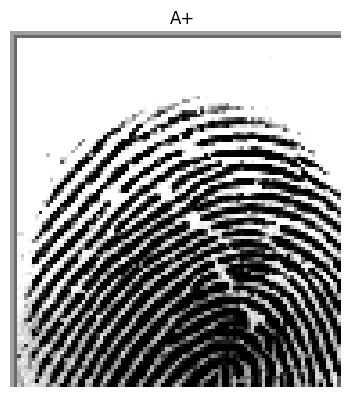

In [5]:
img = view_random_image("dataset_blood_group/", "A+")

In [6]:
# Load dataset
dataset = image_dataset_from_directory(
    dataset_path,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (64, 64),
    batch_size = BATCH_SIZE,
    shuffle = True
)

Found 6000 files belonging to 8 classes.


I0000 00:00:1744615422.513324     501 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [7]:
# Class distribution
class_names = dataset.class_names
class_counts = Counter()
for _, labels in dataset.unbatch():
    class_counts[int(labels.numpy())] += 1

print("Class Distribution:")
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count}")

Class Distribution:
B-: 741
AB-: 761
AB+: 708
O-: 712
A-: 1009
O+: 852
A+: 565
B+: 652


2025-04-14 07:23:59.229554: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_names, class_counts):
    """
    Plots the distribution of classes in the dataset.

    Parameters:
    - class_names (list): List of class names.
    - class_counts (dict): Dictionary with class indices as keys and counts as values

    Returns:
    - None
    """
    # Extract class names and their corresponding counts
    classes = [class_names[i] for i in class_counts.keys()]
    counts = [class_counts[i] for i in class_counts.keys()]

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')

    # Add titles and labels
    plt.title("Class Distribution in dataset", fontsize = 16)
    plt.xlabel("Classes", fontsize = 14)
    plt.ylabel("Number of samples", fontsize = 14)

    # To show to count on the top of each bar
    for i, count in enumerate(counts):
        plt.text(i,count, str(counts[i]), ha = "center", va = "bottom", fontsize = 12)

    plt.xticks(rotation = 45)
    #plt.tight_layout()
    plt.show

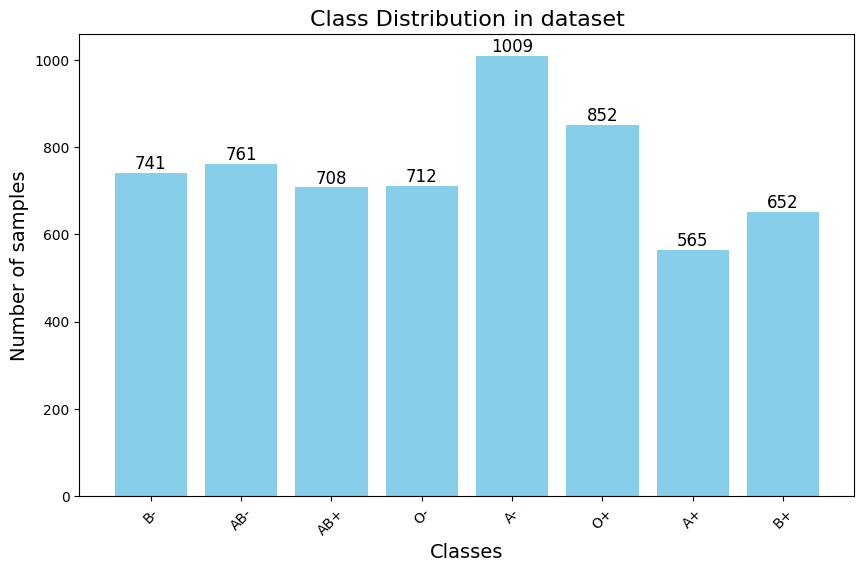

In [9]:
plot_class_distribution(class_names, class_counts)

In [10]:
max_counts = max(class_counts.values())

In [11]:
max_counts

1009

In [12]:
augmentation = ImageDataGenerator(rotation_range=20, # note: this is an int not a float
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

In [13]:
for i in dataset.take(10):
    print(i[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


2025-04-14 07:24:32.726422: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
# Function to oversample a class
def oversample_class(class_id, count, max_counts):
    # Ensure the dataset is unbatched for filtering
    unbatched_dataset = dataset.unbatch()

    # Filter the dataset for the specific class
    class_dataset = unbatched_dataset.filter(lambda img, lbl: tf.math.equal(lbl, class_id))

    # Calculate the number of repetitions needed
    repeat_factor = max_counts // count + (max_counts % count > 0)

    # Repeat the dataset to match the desired count
    return class_dataset.repeat(repeat_factor).take(max_counts)

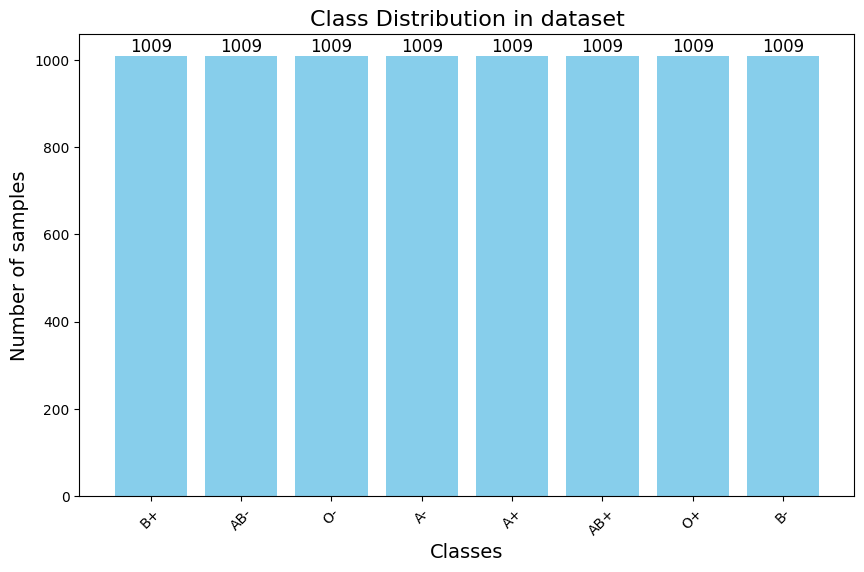

In [15]:
# Balance the datasets
balanced_datasets = []
for class_id, count in class_counts.items():
    balanced_datasets.append(oversample_class(class_id, count, max_counts))

# Combine balanced datasets
balanced_datasets = tf.data.Dataset.sample_from_datasets(balanced_datasets)

# Check the balanced class distribution
balanced_class_counts = Counter([int(lbl.numpy()) for _, lbl in balanced_datasets])
plot_class_distribution(class_names, balanced_class_counts)

# Batch the balanced dataset
balanced_dataset = balanced_datasets.batch(BATCH_SIZE, drop_remainder=True)

In [16]:
balanced_class_counts.total()

8072

In [17]:
for sample in balanced_dataset.take(10):
    print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


2025-04-14 07:25:54.840303: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
train_ratio = 0.7
val_ratio = 0.2
DATASET_SIZE = balanced_class_counts.total()

In [19]:
DATASET_SIZE

8072

In [20]:
balanced_dataset_unbatched = balanced_dataset.unbatch()
dataset_size = sum(1 for _ in balanced_dataset_unbatched)
print(f"Total dataset size: {dataset_size}")

Total dataset size: 8064


In [21]:
# Unbatch the dataset to work at the sample level
balanced_dataset_unbatch = balanced_dataset.unbatch()

# Compute sizes based on dataset size and desired splits
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)

# Split the dataset into training, validation, and test
train_dataset = balanced_dataset_unbatch.take(train_size)
val_test_dataset = balanced_dataset_unbatch.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

# Rebatch the datasets after splitting
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

print(f"Training dataset size: {sum(1 for _ in train_dataset) * BATCH_SIZE}")
print(f"Validation dataset size: {sum(1 for _ in val_dataset) * BATCH_SIZE}")
print(f"Testing dataset size: {sum(1 for _ in test_dataset) * BATCH_SIZE}")

Training dataset size: 5632
Validation dataset size: 1600
Testing dataset size: 800


2025-04-14 07:28:51.156445: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
def model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape = (64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation = 'relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer = 'Adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

model = model()

/home/rajat_paliwal/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 3,
    min_lr = 1e-6
)

early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

In [24]:
# Train the model
history_model = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 50,
    callbacks = [reduce_lr, early_stop]
)

Epoch 1/50


I0000 00:00:1744615761.579220     617 service.cc:152] XLA service 0x7fb1f400fa60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744615761.579295     617 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-04-14 07:29:21.717484: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744615762.241919     617 cuda_dnn.cc:529] Loaded cuDNN version 90300


      1/Unknown 16s 16s/step - accuracy: 0.1562 - loss: 222.5434

I0000 00:00:1744615774.478636     617 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    176/Unknown 39s 133ms/step - accuracy: 0.1423 - loss: 41.0419

2025-04-14 07:29:57.996993: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:29:57.997076: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556
/home/rajat_paliwal/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-04-14 07:30:23.743884: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_108', 4 bytes spill stores, 4 bytes spill loads

2025-04-14 07:30:23.752646: I external/local_xla/xla/stream_executor/cuda/subprocess_c

176/176 ━━━━━━━━━━━━━━━━━━━━ 74s 335ms/step - accuracy: 0.1425 - loss: 40.8703 - val_accuracy: 0.1813 - val_loss: 2.0252 - learning_rate: 0.0010
Epoch 2/50


2025-04-14 07:30:33.180777: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:30:33.180888: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.2752 - loss: 1.8391

2025-04-14 07:30:58.114543: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:30:58.114615: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 56s 317ms/step - accuracy: 0.2754 - loss: 1.8386 - val_accuracy: 0.3381 - val_loss: 1.8500 - learning_rate: 0.0010
Epoch 3/50


2025-04-14 07:31:29.614329: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-04-14 07:31:29.614431: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:31:29.614484: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.4293 - loss: 1.4796

2025-04-14 07:31:54.211708: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:31:54.211792: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 57s 320ms/step - accuracy: 0.4296 - loss: 1.4789 - val_accuracy: 0.4306 - val_loss: 1.5779 - learning_rate: 0.0010
Epoch 4/50


2025-04-14 07:32:26.481782: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:32:26.481872: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5833 - loss: 1.1436

2025-04-14 07:32:51.651467: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:32:51.651552: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 59s 330ms/step - accuracy: 0.5834 - loss: 1.1434 - val_accuracy: 0.5806 - val_loss: 1.3655 - learning_rate: 0.0010
Epoch 5/50


2025-04-14 07:33:25.007886: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:33:25.007973: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6269 - loss: 1.0036

2025-04-14 07:33:50.352415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:33:50.352485: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 57s 321ms/step - accuracy: 0.6270 - loss: 1.0033 - val_accuracy: 0.7219 - val_loss: 0.9815 - learning_rate: 0.0010
Epoch 6/50


2025-04-14 07:34:22.036645: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:34:22.036721: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.6747 - loss: 0.8730

2025-04-14 07:34:46.665715: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:34:46.665781: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 57s 319ms/step - accuracy: 0.6748 - loss: 0.8730 - val_accuracy: 0.6850 - val_loss: 1.1269 - learning_rate: 0.0010
Epoch 7/50


2025-04-14 07:35:18.647266: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-04-14 07:35:18.647334: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:35:18.647367: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7028 - loss: 0.8018

2025-04-14 07:35:43.467808: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:35:43.467878: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 57s 320ms/step - accuracy: 0.7028 - loss: 0.8017 - val_accuracy: 0.6725 - val_loss: 1.1084 - learning_rate: 0.0010
Epoch 8/50


2025-04-14 07:36:15.544926: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:36:15.545044: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7329 - loss: 0.7511

2025-04-14 07:36:40.167616: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:36:40.167687: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 57s 319ms/step - accuracy: 0.7329 - loss: 0.7512 - val_accuracy: 0.7088 - val_loss: 1.1069 - learning_rate: 0.0010
Epoch 9/50


2025-04-14 07:37:12.261048: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:37:12.261185: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7535 - loss: 0.6616

2025-04-14 07:37:37.824555: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:37:37.824637: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 58s 325ms/step - accuracy: 0.7536 - loss: 0.6615 - val_accuracy: 0.8106 - val_loss: 0.8525 - learning_rate: 5.0000e-04
Epoch 10/50


2025-04-14 07:38:09.840982: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:38:09.841127: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7758 - loss: 0.6048

2025-04-14 07:38:38.088109: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:38:38.088197: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 60s 339ms/step - accuracy: 0.7758 - loss: 0.6048 - val_accuracy: 0.8531 - val_loss: 0.8269 - learning_rate: 5.0000e-04
Epoch 11/50


2025-04-14 07:39:10.040660: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:39:10.040748: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7761 - loss: 0.5885

2025-04-14 07:39:37.968415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:39:37.968488: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 60s 340ms/step - accuracy: 0.7761 - loss: 0.5885 - val_accuracy: 0.8556 - val_loss: 0.7748 - learning_rate: 5.0000e-04
Epoch 12/50


2025-04-14 07:40:10.463550: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:40:10.463663: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8012 - loss: 0.5379

2025-04-14 07:40:34.842276: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:40:34.842356: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 56s 318ms/step - accuracy: 0.8011 - loss: 0.5380 - val_accuracy: 0.8300 - val_loss: 0.7443 - learning_rate: 5.0000e-04
Epoch 13/50


2025-04-14 07:41:06.968788: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:41:06.968880: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8022 - loss: 0.5387

2025-04-14 07:41:31.644004: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:41:31.644071: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 56s 318ms/step - accuracy: 0.8022 - loss: 0.5387 - val_accuracy: 0.8662 - val_loss: 0.7055 - learning_rate: 5.0000e-04
Epoch 14/50


2025-04-14 07:42:03.415905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:42:03.416003: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8069 - loss: 0.5239

2025-04-14 07:42:28.677633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:42:28.677705: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 57s 321ms/step - accuracy: 0.8069 - loss: 0.5239 - val_accuracy: 0.8794 - val_loss: 0.7564 - learning_rate: 5.0000e-04
Epoch 15/50


2025-04-14 07:43:00.586796: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-04-14 07:43:00.586869: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:43:00.586899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


173/176 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7998 - loss: 0.5154

2025-04-14 07:43:25.619565: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:43:25.619655: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 58s 328ms/step - accuracy: 0.7998 - loss: 0.5156 - val_accuracy: 0.8988 - val_loss: 0.6284 - learning_rate: 5.0000e-04
Epoch 16/50


2025-04-14 07:43:58.786609: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:43:58.786698: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8031 - loss: 0.5123

2025-04-14 07:44:24.149544: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:44:24.149611: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 59s 332ms/step - accuracy: 0.8031 - loss: 0.5123 - val_accuracy: 0.8450 - val_loss: 0.6429 - learning_rate: 5.0000e-04
Epoch 17/50


2025-04-14 07:44:57.789067: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:44:57.789141: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8114 - loss: 0.4785

2025-04-14 07:45:27.025868: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:45:27.025941: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 65s 364ms/step - accuracy: 0.8114 - loss: 0.4786 - val_accuracy: 0.7706 - val_loss: 0.7886 - learning_rate: 5.0000e-04
Epoch 18/50


2025-04-14 07:46:02.366729: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:46:02.366829: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7986 - loss: 0.5219

2025-04-14 07:46:31.544855: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:46:31.544934: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 64s 366ms/step - accuracy: 0.7987 - loss: 0.5218 - val_accuracy: 0.8963 - val_loss: 0.6044 - learning_rate: 5.0000e-04
Epoch 19/50


2025-04-14 07:47:06.111978: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:47:06.112110: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8050 - loss: 0.4945

2025-04-14 07:47:31.970360: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:47:31.970432: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 62s 351ms/step - accuracy: 0.8051 - loss: 0.4944 - val_accuracy: 0.9000 - val_loss: 0.5479 - learning_rate: 5.0000e-04
Epoch 20/50


2025-04-14 07:48:08.365456: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:48:08.365529: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8234 - loss: 0.4902

2025-04-14 07:48:39.129449: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:48:39.129518: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 68s 387ms/step - accuracy: 0.8233 - loss: 0.4903 - val_accuracy: 0.8925 - val_loss: 0.5830 - learning_rate: 5.0000e-04
Epoch 21/50


2025-04-14 07:49:15.918735: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:49:15.918832: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8157 - loss: 0.4708

2025-04-14 07:49:42.175834: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:49:42.175929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 59s 330ms/step - accuracy: 0.8157 - loss: 0.4709 - val_accuracy: 0.8244 - val_loss: 0.7813 - learning_rate: 5.0000e-04
Epoch 22/50


2025-04-14 07:50:14.554850: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:50:14.554924: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8181 - loss: 0.4668

2025-04-14 07:50:42.614582: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:50:42.614672: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 60s 339ms/step - accuracy: 0.8181 - loss: 0.4668 - val_accuracy: 0.8594 - val_loss: 0.6226 - learning_rate: 5.0000e-04
Epoch 23/50


2025-04-14 07:51:14.767131: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:51:14.767222: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8283 - loss: 0.4311

2025-04-14 07:51:44.488764: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:51:44.488853: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 62s 350ms/step - accuracy: 0.8284 - loss: 0.4310 - val_accuracy: 0.9175 - val_loss: 0.5231 - learning_rate: 2.5000e-04
Epoch 24/50


2025-04-14 07:52:16.809755: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:52:16.809851: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8483 - loss: 0.3894

2025-04-14 07:52:44.378443: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:52:44.378532: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 59s 334ms/step - accuracy: 0.8483 - loss: 0.3894 - val_accuracy: 0.9069 - val_loss: 0.4953 - learning_rate: 2.5000e-04
Epoch 25/50


2025-04-14 07:53:16.128250: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:53:16.128334: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8553 - loss: 0.3747

2025-04-14 07:53:42.845859: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:53:42.845949: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 59s 331ms/step - accuracy: 0.8553 - loss: 0.3747 - val_accuracy: 0.9219 - val_loss: 0.4532 - learning_rate: 2.5000e-04
Epoch 26/50


2025-04-14 07:54:14.966722: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:54:14.966785: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8631 - loss: 0.3745

2025-04-14 07:54:41.753651: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:54:41.753737: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 59s 331ms/step - accuracy: 0.8630 - loss: 0.3746 - val_accuracy: 0.9175 - val_loss: 0.4799 - learning_rate: 2.5000e-04
Epoch 27/50


2025-04-14 07:55:13.642197: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:55:13.642270: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8518 - loss: 0.3661

2025-04-14 07:55:40.314771: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:55:40.314901: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 59s 331ms/step - accuracy: 0.8518 - loss: 0.3662 - val_accuracy: 0.9206 - val_loss: 0.4946 - learning_rate: 2.5000e-04
Epoch 28/50


2025-04-14 07:56:12.322796: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:56:12.322882: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8596 - loss: 0.3624

2025-04-14 07:56:39.341811: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:56:39.341901: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 59s 333ms/step - accuracy: 0.8596 - loss: 0.3626 - val_accuracy: 0.9081 - val_loss: 0.4982 - learning_rate: 2.5000e-04
Epoch 29/50


2025-04-14 07:57:11.603783: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:57:11.603857: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8609 - loss: 0.3457

2025-04-14 07:57:38.694849: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:57:38.694946: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 60s 336ms/step - accuracy: 0.8609 - loss: 0.3458 - val_accuracy: 0.9312 - val_loss: 0.4516 - learning_rate: 1.2500e-04
Epoch 30/50


2025-04-14 07:58:11.292905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:58:11.292980: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8648 - loss: 0.3531

2025-04-14 07:58:38.111014: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:58:38.111090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 59s 331ms/step - accuracy: 0.8648 - loss: 0.3531 - val_accuracy: 0.9331 - val_loss: 0.4322 - learning_rate: 1.2500e-04
Epoch 31/50


2025-04-14 07:59:10.143420: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-04-14 07:59:10.143487: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:59:10.143518: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8748 - loss: 0.3228

2025-04-14 07:59:38.363198: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 07:59:38.363291: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 64s 362ms/step - accuracy: 0.8748 - loss: 0.3229 - val_accuracy: 0.9256 - val_loss: 0.3984 - learning_rate: 1.2500e-04
Epoch 32/50


2025-04-14 08:00:14.347415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:00:14.347493: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


168/176 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.8668 - loss: 0.3560

2025-04-14 08:00:41.363405: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:00:41.363490: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 59s 335ms/step - accuracy: 0.8667 - loss: 0.3555 - val_accuracy: 0.9375 - val_loss: 0.4157 - learning_rate: 1.2500e-04
Epoch 33/50


2025-04-14 08:01:13.875535: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:01:13.875741: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8651 - loss: 0.3411

2025-04-14 08:01:41.681626: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:01:41.681713: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 63s 356ms/step - accuracy: 0.8651 - loss: 0.3411 - val_accuracy: 0.9350 - val_loss: 0.3886 - learning_rate: 1.2500e-04
Epoch 34/50


2025-04-14 08:02:17.040018: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:02:17.040154: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8776 - loss: 0.3158

2025-04-14 08:02:46.865367: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:02:46.865484: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 64s 363ms/step - accuracy: 0.8775 - loss: 0.3159 - val_accuracy: 0.9362 - val_loss: 0.4127 - learning_rate: 1.2500e-04
Epoch 35/50


2025-04-14 08:03:21.434090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:03:21.434164: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


171/176 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8756 - loss: 0.3185

2025-04-14 08:03:48.764953: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:03:48.765046: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 60s 340ms/step - accuracy: 0.8755 - loss: 0.3188 - val_accuracy: 0.9319 - val_loss: 0.3907 - learning_rate: 1.2500e-04
Epoch 36/50


2025-04-14 08:04:21.760724: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:04:21.760811: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8718 - loss: 0.3260

2025-04-14 08:04:49.856053: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:04:49.856148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 63s 353ms/step - accuracy: 0.8717 - loss: 0.3261 - val_accuracy: 0.9312 - val_loss: 0.4103 - learning_rate: 1.2500e-04
Epoch 37/50


2025-04-14 08:05:24.386407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:05:24.386502: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8798 - loss: 0.3239

2025-04-14 08:05:52.399296: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:05:52.399385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 63s 354ms/step - accuracy: 0.8798 - loss: 0.3239 - val_accuracy: 0.9325 - val_loss: 0.4060 - learning_rate: 6.2500e-05
Epoch 38/50


2025-04-14 08:06:27.154281: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:06:27.154360: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8819 - loss: 0.3061

2025-04-14 08:06:54.768974: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:06:54.769040: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 62s 352ms/step - accuracy: 0.8818 - loss: 0.3061 - val_accuracy: 0.9369 - val_loss: 0.3734 - learning_rate: 6.2500e-05
Epoch 39/50


2025-04-14 08:07:29.612676: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:07:29.612742: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8800 - loss: 0.2919

2025-04-14 08:07:57.235128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:07:57.235200: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 63s 355ms/step - accuracy: 0.8800 - loss: 0.2919 - val_accuracy: 0.9488 - val_loss: 0.3558 - learning_rate: 6.2500e-05
Epoch 40/50


2025-04-14 08:08:32.624370: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:08:32.624447: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8916 - loss: 0.2879

2025-04-14 08:09:00.523358: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:09:00.523427: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 63s 353ms/step - accuracy: 0.8916 - loss: 0.2880 - val_accuracy: 0.9400 - val_loss: 0.3759 - learning_rate: 6.2500e-05
Epoch 41/50


2025-04-14 08:09:35.295792: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:09:35.295862: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8864 - loss: 0.2928

2025-04-14 08:10:02.598900: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:10:02.598989: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 61s 347ms/step - accuracy: 0.8864 - loss: 0.2928 - val_accuracy: 0.9419 - val_loss: 0.3731 - learning_rate: 6.2500e-05
Epoch 42/50


2025-04-14 08:10:36.770910: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:10:36.770989: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8815 - loss: 0.3070

2025-04-14 08:11:04.605394: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:11:04.605480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 63s 357ms/step - accuracy: 0.8815 - loss: 0.3070 - val_accuracy: 0.9413 - val_loss: 0.3721 - learning_rate: 6.2500e-05
Epoch 43/50


2025-04-14 08:11:40.148560: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:11:40.148625: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8877 - loss: 0.2826

2025-04-14 08:12:06.153939: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:12:06.154003: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 60s 339ms/step - accuracy: 0.8877 - loss: 0.2827 - val_accuracy: 0.9425 - val_loss: 0.3613 - learning_rate: 3.1250e-05
Epoch 44/50


2025-04-14 08:12:40.269427: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:12:40.269559: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8868 - loss: 0.2857

2025-04-14 08:13:06.007869: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:13:06.007940: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


176/176 ━━━━━━━━━━━━━━━━━━━━ 58s 325ms/step - accuracy: 0.8868 - loss: 0.2857 - val_accuracy: 0.9406 - val_loss: 0.3575 - learning_rate: 3.1250e-05


2025-04-14 08:13:37.964205: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:13:37.964278: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556


In [25]:
import pickle

# Save the entire History object
with open('history_model.pkl', 'wb') as f:
    pickle.dump(history_model, f)

In [41]:
model.save("Blood_group_detection.h5")


In [42]:
model.save('Blood_group_detection.keras')

In [28]:
# Evaluate on the validation data
model_eval = model.evaluate(val_dataset)
print(f"Model accuracy model - {model_eval}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - accuracy: 0.9542 - loss: 0.3548
Model accuracy model - [0.3600122332572937, 0.9462500214576721]


2025-04-14 08:19:41.309385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15186168220403207173
2025-04-14 08:19:41.309498: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9250286742721937556
/home/rajat_paliwal/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [29]:
model_eval

[0.3600122332572937, 0.9462500214576721]

In [27]:
model = tf.keras.models.load_model('Blood_group_detection.keras')

/home/rajat_paliwal/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [28]:
model

<Sequential name=sequential, built=True>

In [2]:
from tensorflow.keras.models import load_model

In [10]:
model = load_model("D:/Project/Blood-Group-Detection/Model/Blood_group_detection.h5")

In [31]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

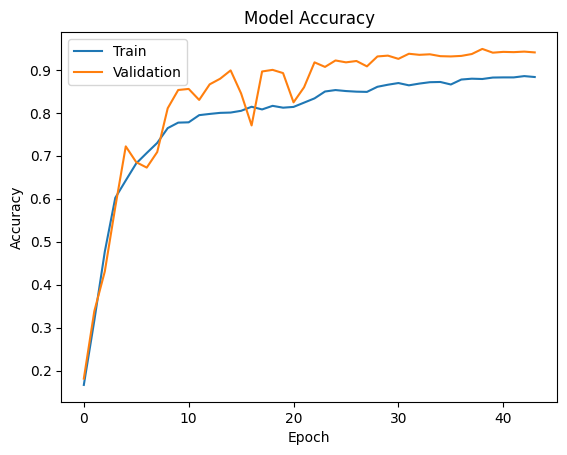

In [32]:
plot_accuracy(history_model)

I0000 00:00:1742562278.725826    7123 service.cc:152] XLA service 0x7f03e4002f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742562278.726485    7123 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-03-21 13:04:38.780876: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742562278.897120    7123 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-21 13:04:39.714636: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_95', 4 bytes spill stores, 4 bytes spill loads

2025-03-21 13:04:39.814923: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_do

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


I0000 00:00:1742562282.951247    7123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Classification Report: 
              precision    recall  f1-score   support

          A+       0.95      0.95      0.95    

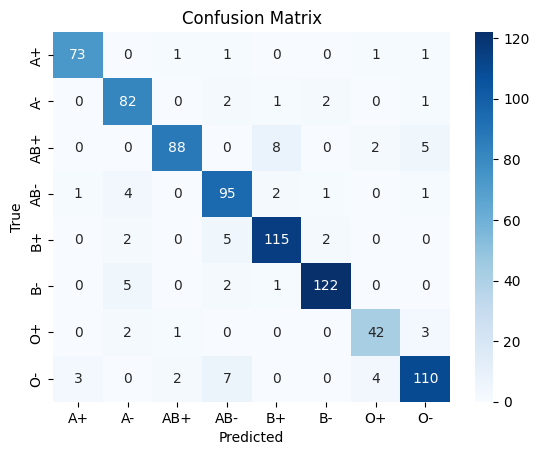

<Figure size 640x480 with 0 Axes>

In [30]:
y_true = []
y_pred = []

for image, labels in test_dataset:
    predictions = model.predict(image)
    predicted_labels = np.argmax(predictions, axis = 1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report: ")
print(report)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = "Blues", xticklabels=class_names, yticklabels = class_names)
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
plt.savefig('Model.png')